# Hands-on Lab 8: SVD/PCA Classification for Voice Commands

### EECS 16B: Designing Information Devices and Systems II, Spring 2023

Written by Nathaniel Mailoa and Emily Naviasky (2016). 

Updated by Julian Chan (2018), Peter Schafhalter (2019). Vin Ramamurti and Zain Zaidi (Fall 2019)

Updated by Kaitlyn Chan, Steven Lu (2021)

Updated by Steven Lu, Megan Zeng, Ke Wang (2022)

Updated by Shrey Aeron, Mingyang Wang, Megan Zeng (2022)

Updated by Jessica Fan (2023)

## Table of Contents

* [Introduction / Lab Note](#intro)

### Project Part A

* [Part 0: Preparing your Arduino](#part0)
* [Part 1: Setting up your Circuit](#part1)
* [Part 2: Data Collection](#part2)
* [Part 3: Data Preprocessing](#part3)

### Project Part B

* [Part 4: PCA via SVD](#part4)
* [Part 5: Clustering Data Points](#part5)
* [Part 6: Testing your Classifier](#part6)
* [Part 7: Arduino Implementation of PCA Classify](#part7)
* [Appendix: Formatting Vectors for Arduino](#appendix)

### Other
* [Part 8: Final Lab Report Questions](#part8)

<a id='intro'></a>
## <span style="color:navy">Introduction</span>

S1XT33N is an obedient little robot that will follow the directions that you tell it. In Lab 7, you implemented the controller to enable S1XT33N to drive straight and turn. Now, we will implement voice control, and then put it all together in the last lab for a complete voice-controlled car!

Unfortunately, S1XT33N does not understand our language, and some words, like "left" and "right," sound very similar to S1XT33N (a strong single syllable), while other words are easier to distinguish. 

In this lab, we aim to find four command words that are easy for S1XT33N to tell apart (consider syllables and intonation). In order to do so, we will develop the SVD classifier that allows S1XT33N to tell the difference between the four commands, and then examine several different words and determine which ones will be easiest to classify by PCA.

**Note that Lab 8 is intended to span two weeks. We split this lab into two phases as a recommendation of time allocation.**

**Please read the  [lab note](https://eecs16b.org/lab/notes/lab_note8.pdf). It explains in detail what you will be doing in each part of the lab.**

## Pre-Lab

Complete the pre-lab assignment before doing the lab. Submit your answers to the Gradescope assignment ["[Lab] Pre-Lab 8: Classification"](https://www.gradescope.com/courses/484565/assignments/2809935/). Pre-Lab 8 is due on **April 23rd at 11:59pm**. No late submissions will be accepted.

## Help Request Form
Use this [form](https://eecs16b.org/lab-help) to request help in your debugging / conceptual needs.


### Overview of Classification Procedure
Below is an overview of the classification procedure we will be following in this lab.
1. Collect recordings of 6 different words. This will form our data set
2. Preprocess the data to align the words
2. Split the data into 2 sets: training and testing data
3. Perform SVD and evaluate on the training data split
4. Select the 4 best words to use as your commands
5. Classify each word using clustering in the PCA basis
6. Evaluate perfornace by running the model on testing data
7. Make sure you (and your GSI) are satisfied with the classifier's accuracy.

The goals of this phase are as follows:
- Collect data and preprocess
- Code and run PCA + Classifier on all 4 commands
- Check accuracy

### Side Note: Datasets in Machine Learning Applications
It is common practice in machine learning applications to split a dataset into a training set and testing set (some common ratios for train:test are 80:20 or 70:30). In this lab, we will split 70:30.

<a id='part0'></a>
## <span style="color:navy">Part 0: Preparing your Arduino</span>

For this entire lab, power your car with the stationary configuration below. The Arduino is powered through the USB while the front end circuit is powered through the power supply. Leave the motors unpowered because this lab does not require the motor circuits. **Your batteries should be disconnected.**

<img width="600px" src="images/PowerDiagram_1.png">

<a id='part1'></a>
## <span style="color:navy">Part 1: Verifying your Circuit</span>

### Materials
- Mic board front-end circuit
- Arduino + USB

### Front End Verification

1. Hook up your front end circuit
2. Connect your circuit to the Arduino:
    - **Pin `A2` to the microphone front end circuit output (output of non-inverting amplifier for low-pass filter).**
    - GND pin to the ground rail of the breadboard
3.  **Use the oscilloscope to probe the output of the microphone circuit (output of non-inverting amplifier for low-pass filter).** Make sure the waveform is centered at 2.5V
    - Ensure there is a visible response when you talk/produce some other sound (but not railing). The signal should me _mostly_ flat when there is no sound
    - Tune your micboard to match these parameters if necessary

<a id='part2'></a>
## <span style="color:navy">Part 2: Data Collection</span>

### Materials
- Microphone front-end circuit
- Arduino + USB

We will begin by collecting our data. To do so, choose 6 easily distinguishable words (or sounds) to ensure better classification accuracy.

When humans distinguish words, they listen for temporal and frequency differences to determine what is being said. However, S1XT33N will have to choose much simpler features for classification: syllables, intonation, and magnitude. Keep this in mind when choosing your words.

When you think of speech signals, you might notice that each word/sound has a disctinctive shape. Taking the shape of the magnitude of a signal is called enveloping, exemplified in the plot below. We want to do some filtering to retrieve the envelope of the audio signal, which we will use for calculating the SVD.

<center>
<img width="400px" src="images/proj-envelope.png">
</center>

**Given this information, brainstorm a list of 6 words/sounds to use**

### Tasks

Now we will record 40-45 audio samples for each of your 6 words. We recommend that you split the words among your lab group to maximize variance between the recorded signals. For each word, make sure to note who said it and how it was said (like through a video/audio recording on your phone) so that it is easier to reproduce later for live classification.

Please read the full instructions for these tasks before proceeding.
**For each chosen word, do the following:**
1. Upload the sketch **`collect-data-envelope.ino`** to your Arduino.
    - This sketch records $\approx 2$ seconds of audio sampled every 0.35ms and sends the raw data to your computer.
2. Read in Arduino data using your computer
    - Download and open the `collect-data-envelope` folder to your local computer. Press `Shift + right click` within the file explorer and click "Git Bash here" to open a terminal window in the directory.
    - Make sure the Serial Monitor/Plotter is closed
    - Run **`python collect-data-envelope.py YOUR_WORD.csv`**.
        - This program will capture audio data collected by the Arduino and append it to `YOUR_WORD.csv`. You should see a console output in your Git bash terminal after each sample is recorded. 
3. **When the Arduino light(s) are on, say the word you want to record. The Arduino is recording only when the light(s) on, so finish the word before the LEDs turns off.**
    - The three LEDs on the Arduino will progressively turn on to help you gauge how much time you have.
    - **Pronounce the word consistently**
    - "Good" audio data has a high signal to noise ratio (SNR). Recording words while far away from the microphone may cause your intended word to blend in with background noise. However, speaking too loudly and/or too closely into the mic) may also cause your output to rail. You can probe the microphone output using the oscilloscope to check your output.
    - **We recommend that after taking 3 or 4 recordings for the first time, stop the program (e.g. by pressing Ctrl + C in the command prompt) and check `YOUR_WORD.csv.` make sure that it looks like a sound wave as opposed to being full of super low values. *It might help to graph the data as a line plot in Excel.*** You don't want to record 45 times only to find that your mic board wasn't working.
4. Once you've recorded 40-45 good audio samples of the word (excluding any recordings where you missed the timing, like at the beginning), stop the Python program (e.g. by pressing Ctrl + C in the command prompt).
5. Go into the .csv file and delete outlier samples such that you are left with **exactly 40 audio recordings of the word**. Outliers are often near the beginning and end of the .csv file when you may not be speaking. The best way to help you identity outlier samples is to plot the data using a line plot in Excel (you can plot individual rows to identify specific recordings). **Don't worry about aligning the data,** we will account for this in Part 3!
6. If you are working on the lab on DataHub, you will need to upload your `.csv` files to DataHub into the `PCA_data` folder so the Jupyter notebook can access them.


### Before moving on, please note that:

You may realize in the next section that one or two of your words are not sorting quite as well as you would like. Don't be afraid to come back to this section and try collecting different words based on what you have learned makes a word sortable. 

<a id='part3'></a>
## <span style="color:navy">Part 3: Data Preprocessing</span>

Different recordings of the same word can look wildly different, depending on factors like when you started saying the word and how quickly you said it (assuming you are not a robot that can repeat the word 50 times exactly the same way). Thus, before we can use the recorded data for PCA, we must first process the data. 

Using the Arduino, we have already implemented the first step of processing the audio recording: enveloping. It is not necessary for you to understand the enveloping function well enough to implement it (since we have already done it for you), but just in case you are curious, the enveloping function is described in the following pseudocode:

<code><b>Enveloping function</b>\
Divide the whole signal to a block of 16 samples\
For each chunk:\
    Find the mean of the chunk\
    Subtract each sample by the mean\
    Find the sum of the absolute value of each sample
</code>

### 3.1 Load Data from CSV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import csv
import utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

cm = ['blue', 'red', 'green', 'orange', 'black', 'purple']

In [2]:
# YOUR CODE HERE: Fill in the six words you recorded
all_words_arr = ['Abracadabra', 'Alex', 'California', 'Cracker', 'Mississippi', 'ScoobyDoo']

Let's begin by splitting our data into a training and testing set with a 70/30 split. Run the code below to do so.

In [3]:
# Load data from csv
train_test_split_ratio = 0.7
train_dict = {}
test_dict = {}

# Build the dictionary of train and test samples.
for i in range(len(all_words_arr)):
    word_raw = utils.read_csv("PCA_data/{}.csv".format(all_words_arr[i]))
    word_raw_train, word_raw_test = utils.train_test_split(word_raw, train_test_split_ratio)
    train_dict[all_words_arr[i]] = word_raw_train
    test_dict[all_words_arr[i]] = word_raw_test

# Count the minimum number of samples you took across the six recorded words. These variables might be useful for you!
num_samples_train = min(list(map(lambda x : np.shape(x)[0], train_dict.values())))
num_samples_test = min(list(map(lambda x : np.shape(x)[0], test_dict.values())))

# Crop the number of samples for each word to the minimum number so all words have the same number of samples.
for key, raw_word in train_dict.items():
    train_dict[key] = raw_word[:num_samples_train,:]

for key, raw_word in test_dict.items():
    test_dict[key] = raw_word[:num_samples_test,:]


Plot your training data and visualize the enveloped version.

**<span style="color:red">Important: It's okay if the recordings aren't aligned. The code in the next part will align the data.</span>** 

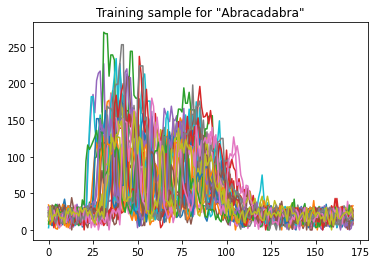

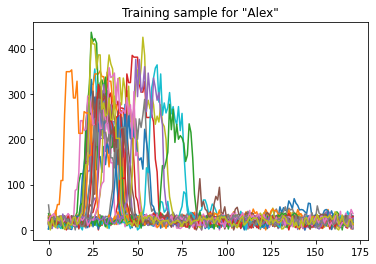

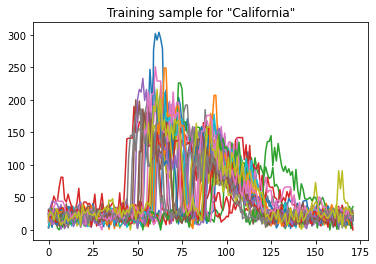

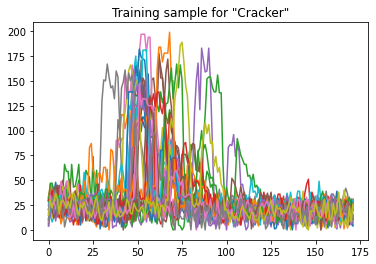

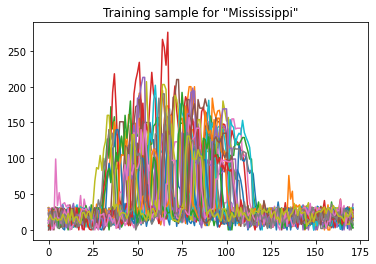

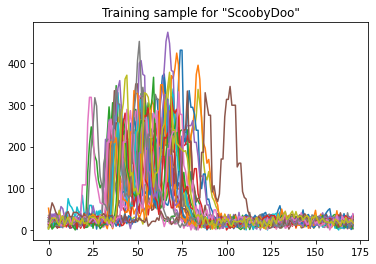

In [4]:
# Plot all training samples
word_number = 0
selected_words_arr = all_words_arr
for word_raw_train in train_dict.values():
    plt.plot(word_raw_train.T)
    plt.title('Training sample for "{}"'.format(selected_words_arr[word_number]))
    word_number += 1
    plt.show()

### 3.2 Align Audio Recordings

As seen above, the speech is a fraction of the 2 second window, and each sample starts at different times. PCA is not good at interpreting delay, so we need to align the recordings and trim to a smaller segment of the sample where the speech is present. To do this, we will use a thresholding algorithm.

First, we define a **`threshold`** relative to the maximum value of the data. We say that any signal that crosses the threshold is the start of a speech command. In order to not lose the first couple samples of the speech command, we say that the command starts **`pre_length`** samples _before_ the threshold is crossed. We then use a window of the data that is **`length`** long, and try to capture the entire command in that window.

<b>The parameters `length`, `pre_length` and `threshold`</b> are defined with default values in the cells below. The default length value corresponds to a reasonable length for vectors we can use, because the Arduino has limited storage and memory and cannot store the entire sample.

**Play around with the parameters `length`, `pre_length` and `threshold`** in the cells below to find appropriate values corresponding to your voice and chosen commands. You should see the results and how much of your command you captured in the plots generated below. When you are satisfied, note down the values of length, pre_length and threshold - you will need to add them to the Arduino sketch later.

In [5]:
def get_snippets(data, length, pre_length, threshold):
    """Attempts to align audio samples in data.
    
    Args:
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
    
    Returns:
        Matrix of aligned recordings.
    """
    assert isinstance(data, np.ndarray) and len(data.shape) == 2, "'data' must be a 2D matrix"
    assert isinstance(length, int) and length > 0, "'length' of snippet must be an integer greater than 0"
    assert 0 <= threshold <= 1, "'threshold' must be between 0 and 1"
    snippets = []

    # Iterate over the rows in data
    for recording in data:
        # Find the threshold
        recording_threshold = threshold * np.max(recording)

        # Figure out when interesting snippet starts
        i = pre_length
        while recording[i] < recording_threshold:
            i += 1
            
        snippet_start = min(i - pre_length, len(recording) - length)
        snippet = recording[snippet_start:snippet_start + length]

        # Normalization
        snippet = snippet / np.sum(snippet)
        
        snippets.append(snippet)

    return np.vstack(snippets)

In [6]:
# Wrapper function for get_snippets
def process_data(dict_raw, length, pre_length, threshold, plot=True):
    """
    Process the raw data given parameters and return it.
    
    Args:
        dict_raw (np.ndarray): Raw data collected.
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
        plot (boolean): Plot the dataset if true.
            
    Returns:
        Processed data dictionary.
    """
    processed_dict = {}
    word_number = 0
    for key, word_raw in dict_raw.items():
        word_processed = get_snippets(word_raw, length, pre_length, threshold)
        processed_dict[key] = word_processed
        if plot:
            plt.plot(word_processed.T)
            plt.title('Samples for "{}"'.format(selected_words_arr[word_number]))
            word_number += 1
            plt.show()
            
    return processed_dict 

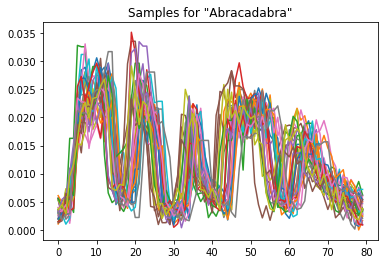

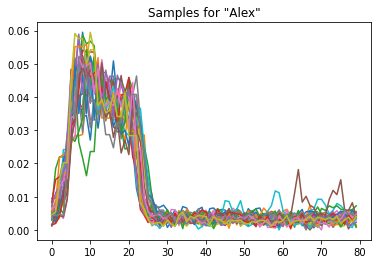

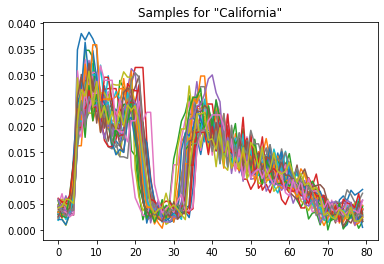

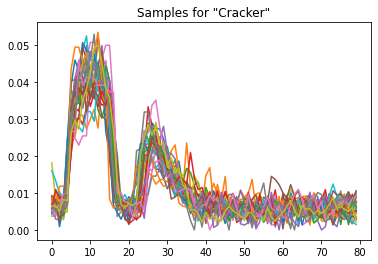

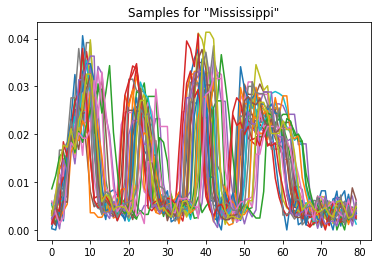

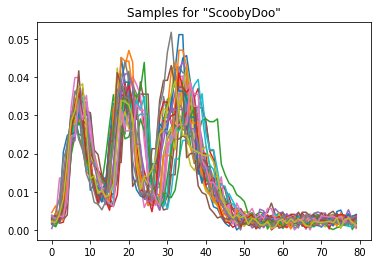

In [7]:
length = 80 # Default: 80
pre_length = 5 # Default: 5
threshold = 0.5 # Default: 0.5

processed_train_dict = process_data(train_dict, length, pre_length, threshold)

You should now notice the improved alignment for the samples. Can you tell which word is which just by the envelope? If any of your words look too similar to each another, then PCA will likely have a difficult time distinguishing between them, so you may want to consider re-choosing/recording more unique words.

<a id='part4'></a>
## <span style="color:navy">Part 4: PCA via SVD</span>

### 4.0 SVD/PCA Resources
- http://www.ams.org/publicoutreach/feature-column/fcarc-svd
- https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
- https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8

### 4.1 Generate and Preprocess PCA Matrix

Now that we have our aligned data, we will build the PCA input matrix from that data by **stacking all the data vertically**.

**Sanity check:** What should be the dimensions of `processed_A`? Feel free to use `np.shape()` if you aren't sure.

In [8]:
processed_A = np.vstack(list(processed_train_dict.values()))
print(np.shape(processed_A))

(174, 80)


The first step of PCA is to center the data's mean at zero and store it in `demeaned_A`. Please note that you want to **get the mean of each feature** (***what are the features?***). The function [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) might be helpful here, along with specifying the `axis` parameter.

<!-- which can be helpful to obtain principal components that are representative of the shape of the variations in the data. -->

**Sanity check:** Does the shape of `mean_vec` make sense given what we averaged across?

In [9]:
# Zero-mean the matrix A
# YOUR CODE HERE
mean_vec = np.mean(processed_A, axis=0)
demeaned_A = processed_A - mean_vec
print(processed_A.shape)
print(mean_vec.shape)

(174, 80)
(80,)


### 4.2 Principal Component Analysis

Next, take the SVD of your demeaned data - `np.linalg.svd` may be useful here. 

In [10]:
# Take the SVD of matrix demeaned_A 
# YOUR CODE HERE #
U, S, Vt = np.linalg.svd(demeaned_A)
print(U.shape, S.shape, Vt.shape)

(174, 174) (80,) (80, 80)


Visually inspect your sigma values. They should tell you how many principal components you need.

<StemContainer object of 3 artists>

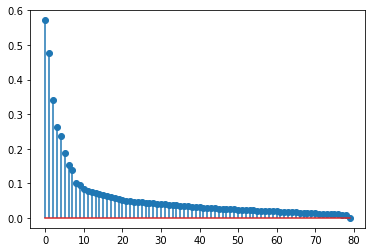

In [11]:
# Plot out the sigma values (Hint: Use plt.stem for a stem plot)
# YOUR CODE HERE #
plt.stem(S)


**<span style="color:red">How many principal components do you need? Given that you are sorting 6 words, what is the number you expect to need?</span>** 

There is no correct answer here. We can pick as many principal components as we want, but we will experience diminshing returns may start capturing noise. In our project, since we are loading these basis vectors onto the Arduino Leonardo, we can only store at most 3 principal components before we run into memory issues.

### 4.3 Choosing a Basis using Principal Components

Set the `new_basis` argument to be a basis of the first 3 principal components. (Hint: Of the three outputs from the SVD function call, which one will contain the principal components onto which we want to project our data points? Do we need to transpose it? **The lab note will help!**)

When you plot `new_basis` you should see a number of line plots equal to the number of principal components you've chosen (3).

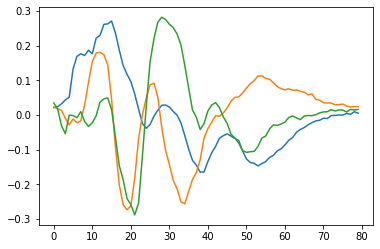

In [12]:
# Plot the principal component(s)
# YOUR CODE HERE
new_basis = np.array(Vt[:3]).transpose()
plt.plot(new_basis)
plt.show()

Now project the data in the matrix A onto the new basis and plot it. For three principal components, in addition to the 3D plot, we also provided 2D plots which correspond to the top and side views of the 3D plot. Do you see clustering? Do you think you can separate the data easily?

(174, 80)
(80, 3)


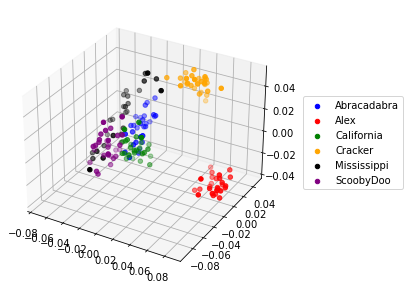

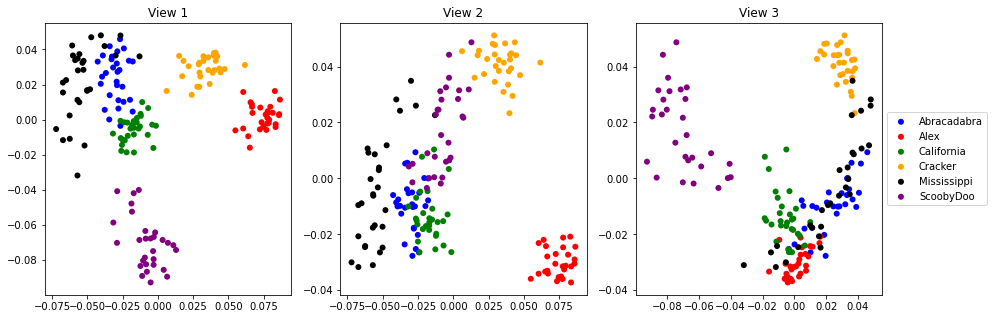

In [13]:
# Project the data onto the new basis
# YOUR CODE HERE. Hint: np.dot() may help, as well as printing the dimensions.
A = demeaned_A
print(A.shape)
print(new_basis.shape)
proj = np.dot(A,new_basis)

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(all_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(all_words_arr)):
        axs[0].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(proj[i*num_samples_train:num_samples_train*(i+1),1], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,5))
    for i in range(len(all_words_arr)):
        plt.scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], edgecolor='none')

    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Like in many AI applications, the data above are noisy, so we expect some classification errors. The important part is that you see strong clustering of your words. 

If you don't see clustering, try to think about why this might be the case. Things you might want to ask yourself:
- How does PCA create the clusters? 
- Which characteristics of your waveform will PCA favor when clustering? 
- How can you choose your words to maximize the differences between the classes?

Once you think you have decent clustering, move on to automating classification. **Choose 4 out of the 6 words which form the most distinct clusters. You will be using these four words for the rest of this lab.**

In [14]:
# YOUR CODE HERE
selected_words_arr = ['Alex', 'Cracker', 'California', 'ScoobyDoo']

# Select data
selected_train_dict = {k: train_dict[k] for k in selected_words_arr}
selected_processed_train_dict = {k: processed_train_dict[k] for k in selected_words_arr}
selected_test_dict = {k: test_dict[k] for k in selected_words_arr}

num_samples_train = min(list(map(lambda x : np.shape(x)[0], selected_train_dict.values())))
num_samples_test = min(list(map(lambda x : np.shape(x)[0], selected_test_dict.values())))

# Reconstruct and demean data based on 4 chosen words.
# Zero-mean the matrix new A
processed_A = np.vstack(list(selected_processed_train_dict.values()))
mean_vec = np.mean(processed_A, axis=0)
demeaned_A = (processed_A-mean_vec)
print(processed_A.shape)
print(mean_vec.shape)

(116, 80)
(80,)


Following the same process as earlier, recalculate the new basis using only your four chosen words so that the basis best represents the four chosen words instead of all of the words.

In [15]:
# Take the SVD of matrix demeaned_A (np.linalg.svd)
# YOUR CODE HERE #
U, S, Vt = np.linalg.svd(demeaned_A)

<StemContainer object of 3 artists>

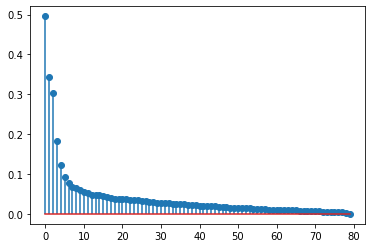

In [16]:
# Plot out the sigma values (Hint: Use plt.stem for a stem plot)
# YOUR CODE HERE #
plt.stem(S)

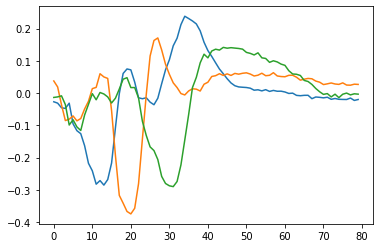

In [17]:
# Plot the principal component(s)
# YOUR CODE HERE
new_basis = Vt[:3].transpose()
plt.plot(new_basis)
plt.show()

The following cell projects the demeaned input matrix onto the new basis to compress the data for more practical classification.

In [18]:
proj = demeaned_A.dot(new_basis)

<a id='part5'></a>
## <span style="color:navy">Part 5: Clustering Data Points</span>

#### Implement `find_centroids`, which finds the center of each cluster.

In [19]:
def find_centroids(clustered_data, num_samples_train):
    """Find the center of each cluster by taking the mean of all points in a cluster.
    It may be helpful to recall how you constructed the data matrix (e.g. which rows correspond to which word)
    
    Parameters:
        clustered_data: the data already projected onto the new basis
        num_samples_train: the number of samples trained
        
    Returns: 
        The centroids of the clusters
    """
    centroids = []
    # YOUR CODE HERE
    # Hint: the variable num_samples_train may help you splice into your clustered_data, as well as np.mean() with the axis option
    # Feel free to ignore the skeleton code if you wish to write it your way.
    for i in range(4):
        center = np.mean(clustered_data[i*num_samples_train:(i+1)*num_samples_train],axis=0)
        centroids.append(center)
    
    
    
    return centroids

Fill in the code below to find the centroids of each cluster.

In [20]:
# Determine the centroids of each cluster
# YOUR CODE HERE: hint: call find_centroids()
centroids = find_centroids(proj, num_samples_train)
print(centroids)

[array([-0.05212525, -0.0397189 ,  0.00239316]), array([-0.0325996 ,  0.04292979, -0.02009293]), array([0.02316974, 0.01285902, 0.04218617]), array([ 0.06155511, -0.01606991, -0.02448641])]


Run the cell below to plot your centroids along with your projected data.

Centroid 0 is at: [-0.05212525 -0.0397189   0.00239316]
Centroid 1 is at: [-0.0325996   0.04292979 -0.02009293]
Centroid 2 is at: [0.02316974 0.01285902 0.04218617]
Centroid 3 is at: [ 0.06155511 -0.01606991 -0.02448641]


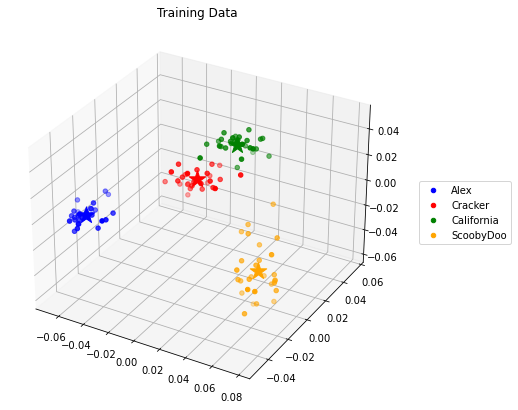

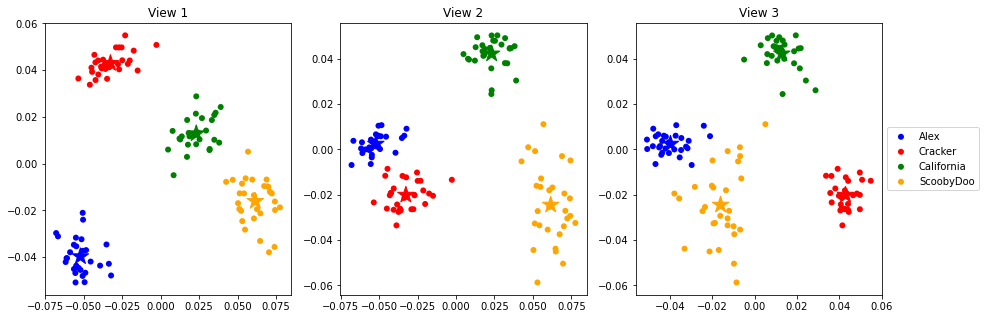

In [21]:
centroid_list = np.vstack(centroids)
colors = cm[:(len(centroids))]

for i, centroid in enumerate(centroid_list):
    print('Centroid {} is at: {}'.format(i, str(centroid)))

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1.07, 0.5))
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *np.array([centroids[i]]).T, c=cm[i], marker = '*', s=300)
    plt.title("Training Data")
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(proj[i*num_samples_train:num_samples_train*(i+1),1], proj[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    axs[1].scatter(centroid_list[:,0], centroid_list[:,2], c=colors, marker='*', s=300)
    axs[2].scatter(centroid_list[:,1], centroid_list[:,2], c=colors, marker='*', s=300)
    plt.show()

elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,7))
    for i in range(len(selected_words_arr)):
        plt.scatter(proj[i*num_samples_train:num_samples_train*(i+1),0], proj[i*num_samples_train:num_samples_train*(i+1),1], c=colors[i], edgecolor='none')

    plt.scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Training Data")
    plt.show()

<a id='part6'></a>
## <span style="color:navy">Part 6: Testing your Classifier</span>

Great! Now that we have the means (centroid) for each word, let's evaluate performance. Recall that we will classify each data point according to the centroid with the least Euclidian distance to it.

Before we perform classification, we need to do the same preprocessing to the test data that we did to the training data (enveloping, demeaning, projecting onto the PCA basis). You have already written most of the code for this part. However, note the difference in variable names as we are now working with test data.

First let's look at what our raw test data looks like.

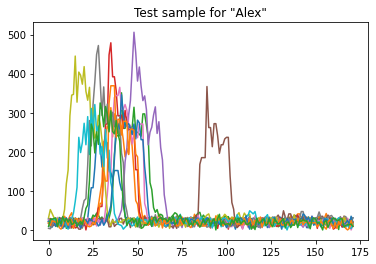

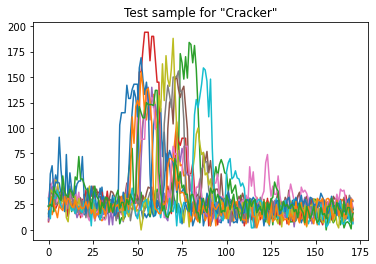

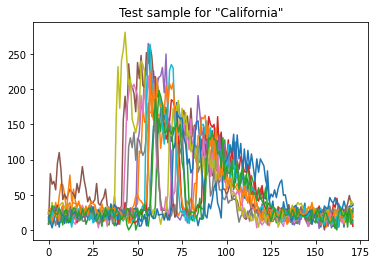

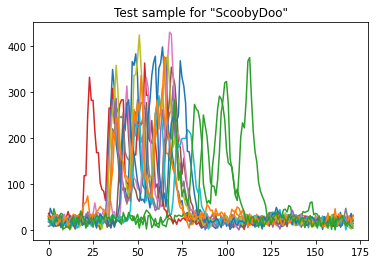

In [22]:
# Plot all test samples
word_number = 0
for word_raw_test in selected_test_dict.values():
    plt.plot(word_raw_test.T)
    plt.title('Test sample for "{}"'.format(selected_words_arr[word_number]))
    word_number += 1
    plt.show()

Perform enveloping and trimming of our test data.

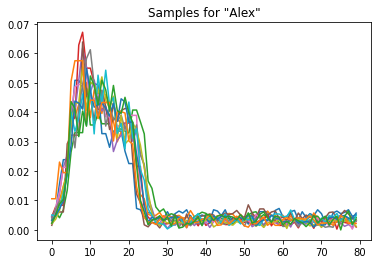

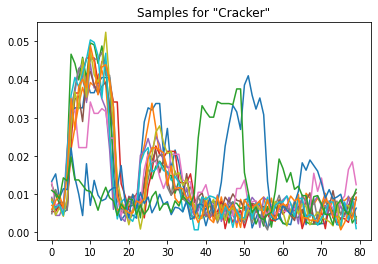

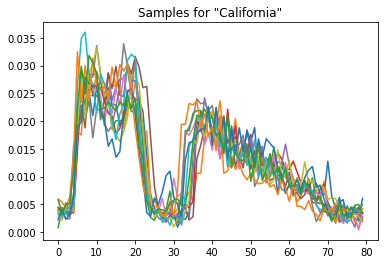

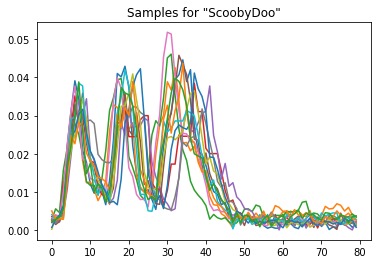

In [23]:
processed_test_dict = process_data(selected_test_dict, length, pre_length, threshold)

Construct the PCA matrix by stacking all the test data.

In [24]:
selected_processed_test_dict = {k: processed_test_dict[k] for k in selected_words_arr}

processed_A_test = np.vstack(list(selected_processed_test_dict.values()))
print(processed_A_test.shape)

(52, 80)


**Now we will do something slightly different.**

Previously, you projected data onto your PCA basis with $ (x - \bar{x})P $, where $\bar{x}$ is the mean vector, $x$ is a single row of `processed_A`, and $P$ is `new_basis`. 

We can rewrite this operation as:

$$ (x - \bar{x})P = xP - \bar{x}P = xP - \bar{x}_{\text{proj}} $$ 
$$ \bar{x}_{\text{proj}} = \bar{x}P $$

Why might we want to do this? We'll later perform these operations on our car. Our Arduinos have limited memory, so we want to store as little as possible. Instead of storing a length $n$ vector $\bar{x}$, we can precompute $ \bar{x}_{\text{proj}} \in \mathbb{R}^3$ and store that instead!

Compute $ \bar{x}_{\text{proj}} $ using the **same mean vector** as the one computed with the training data.

In [25]:
# YOUR CODE HERE
projected_mean_vec = mean_vec.dot(new_basis)

Project the test data onto the **same PCA basis** as the one computed with the training data.

In [26]:
# YOUR CODE HERE
mean_test_vec = np.mean(processed_A_test, axis=0)
projected_A_test = processed_A_test.dot(new_basis)

Zero-mean the projected test data using the **`projected_mean_vec`**.

In [27]:
# YOUR CODE HERE
proj = projected_A_test-projected_mean_vec

Plot the projections to see how well your test data clusters in this new basis. This will give you an idea of test classification accuracy.

/tmp/ipykernel_557/3313378337.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


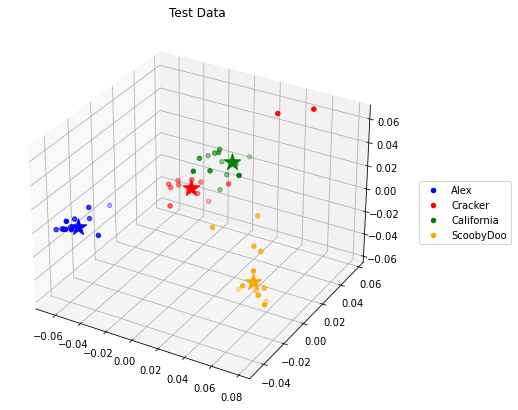

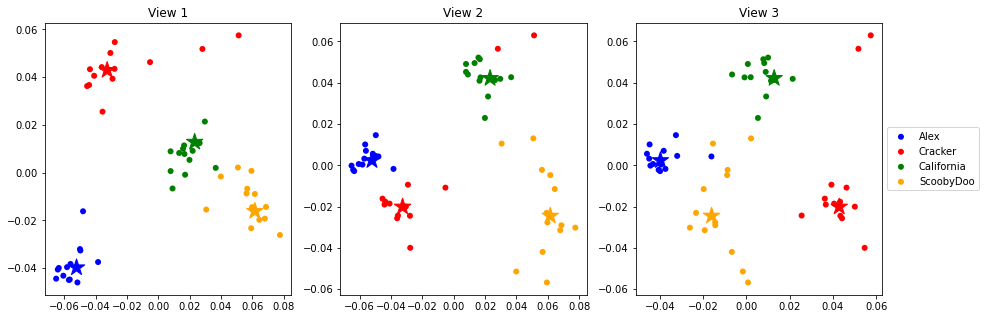

In [28]:
if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_test:num_samples_test*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    plt.title("Test Data")
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *np.array([centroids[i]]).T, c=cm[i], marker = '*', s=300)
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(proj[i*num_samples_test:num_samples_test*(i+1),0], proj[i*num_samples_test:num_samples_test*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(proj[i*num_samples_test:num_samples_test*(i+1),0], proj[i*num_samples_test:num_samples_test*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(proj[i*num_samples_test:num_samples_test*(i+1),1], proj[i*num_samples_test:num_samples_test*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    axs[1].scatter(centroid_list[:,0], centroid_list[:,2], c=colors, marker='*', s=300)
    axs[2].scatter(centroid_list[:,1], centroid_list[:,2], c=colors, marker='*', s=300)
    fig.show()

elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,7))
    for i in range(len(selected_words_arr)):
        plt.scatter(proj[i*num_samples_test:num_samples_test*(i+1),0], proj[i*num_samples_test:num_samples_test*(i+1),1], c=colors[i], edgecolor='none')

    plt.scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Test Data")
    plt.show()

Now that we have some idea of how our test data looks in our PCA basis, let's see how our data actually performs. Implement the `classify` function which takes in a data point after enveloping is applied and returns which word number it belongs to depending on the closed centroid in Euclidian distance.

In [29]:
def classify(data_point, new_basis, projected_mean_vec, centroids):
    """Classifies a new voice recording into a word.
    
    Args:
        data_point: new data point vector before demeaning and projection
        new_basis: the new processed basis to project on
        projected_mean_vec: the same projected_mean_vec as before
    Returns:
        Word number (should be in {1, 2, 3, 4} -> you might need to offset your indexing!)
    Hint:
        Remember to use 'projected_mean_vec'!
        np.argmin(), and np.linalg.norm() may also help!
    """
    # TODO: classify the demeaned data point by comparing its distance to the centroids
    # YOUR CODE HERE
    projected_data_point = data_point.dot(new_basis)
    demeaned = projected_data_point-projected_mean_vec
    
    distances = []
    for centroid in centroids:
            distance = np.linalg.norm(demeaned-centroid,axis=0)
            distances.append(distance)
    return np.argmin(distances, axis=0)+1

Try out the classification function below.

In [30]:
# Try out the classification function
print(classify(processed_A_test[50,:], new_basis, projected_mean_vec, centroids)) # Modify the row index of processed_A_test to use other vectors

4


**Our goal is 80% accuracy for each word.** Apply the `classify` function to each sample and compute the accuracy for each word. If you do not meet 80% accuracy for each word, try to find different combinations of words/parameters that result in more distinct clusters in the plots of the projected data. 

In [31]:
# Try to classify the whole A matrix
correct_counts = np.zeros(4)

for (row_num, data) in enumerate(processed_A_test):
    word_num = row_num // num_samples_test + 1
    if classify(data, new_basis, projected_mean_vec, centroids) == word_num:
        correct_counts[word_num - 1] += 1
        
for i in range(len(correct_counts)):
    print("Percent correct of word {} = {}%".format(i + 1, 100 * correct_counts[i] / num_samples_test))

Percent correct of word 1 = 100.0%
Percent correct of word 2 = 84.61538461538461%
Percent correct of word 3 = 100.0%
Percent correct of word 4 = 84.61538461538461%


<a id='part7'></a>
## <span style="color:navy">Part 7: Arduino Implementation of PCA Classify</span>

### Materials
- Microphone front-end circuit
- Arduino + USB


With our completed classifier, we are now ready to classify live commands using our Arduino. This section will walk you through implementing your classification algorithm on the Arduino. You will need to transfer the preprocessing parameters, PCA vectors, projected mean vector, and centroids all into the Arduino. **You will be copying and pasting the code from the Appendix of the SVD/PCA notebook into `classify.ino.`**

Your first task will be to implement your <b>data processing</b> and <b>classification</b> (just the projection, not the PCA) in the Arduino sketch <b>`classify.ino`</b>. Since Arduino does not have as many built-in functions as Python, you will have to write out the functions yourself. For example, a dot product should be written as:

```C
float dot_product_result = 0;
for (i = 0; i < LENGTH; i++) {
    dot_product_result += vector1[i] * vector2[i];
}
```
where `dot_product_result` is the result of the dot product, and `vector1` and `vector2` are the two vectors you're taking the dot product of.

NOTE: The coding language is a derivative of C/C++, so you need to follow C syntax! i.e. declaring variables before using them, using `{` and `}` to denote the start and end of a for loop, adding a `;` to the ends of lines, etc. You can reference the existing code for examples of how to use the proper syntax.

For debugging purposes, you can add print statements to the code. Printing to the Arduino IDE's Serial Monitor looks like the line below.

`Serial.println("I'm being printed!");`

There are 3 code blocks (`PCA1/2/3`) that you need to modify. <b>You should not have to change anything else outside these marked code blocks and the pin definition if you're using a different pin than the default `A2` pin.</b> 

**`CODE BLOCK PCA1`**
- Copy the `SNIPPET_SIZE`, `PRELENGTH` and `THRESHOLD` from the appendix section of this notebook.
- Set `BASIS_DIM` to be the number of principal components.
- Read the following to set `EUCLIDEAN_THRESHOLD` and `LOUDNESS_THRESHOLD`.

**`EUCLIDEAN_THRESHOLD` filters the classification depending on a sample's distance to the closest centroid.** Look at the plot of your data clusters and the centroids from earlier in this notebook and approximate a radius around the centroids that capture most of the data. **Try to be conservative - it's better to not classify than to misclassify.**

**`LOUDNESS_THRESHOLD` filters the classification depending on the amplitude of the recorded data.** Look at the plots of the audio recordings to determine the loudness of your recordings, then determine an appropriate threshold which isn't low enough to be considered noise. If the Arduino classifies noise, increase this constant. If it misses a lot of speech (i.e. thinks your word is noise), decrease this constant. This variable is used internally in the enveloping function. **Note: this value should be on the scale of 10s to 100s** 

**`CODE BLOCK PCA2`**
- Copy the PCA vectors, projected mean vector, and centroids from the appendix section of the SVD/PCA ipynb.
- If you are using 3 principal components, add a new `pca_vec3` array and make sure `BASIS_DIM` in `CODE BLOCK PCA1` is 3 (default value is 2).
- Note: Using more principal components increases the dimensionality of the centroids and projections, but also consumes more of the limited memory on the Arduino.

**`CODE BLOCK PCA3`**
- This is the actual classification algorithm
- Before this block, the call to `envelope_small` leaves the data vector of your recording in the array called `result`.
- Project this data onto your new PCA basis.
    - **Since the principal component vectors are orthonormal, they have unit norm. Thus when you perform the projection of the recorded data vector onto the principal components, you only need to calculate the dot products between those vectors.**
    - Use just one loop to project your recorded data vector onto both (or all 3, if you're using 3) of your PCA vectors.
    - Use the variables `proj1` and `proj2` to store the projection results. If you're using 3 vectors, create a variable `proj3` in the same way `proj1` and `proj2` are defined.
- Demean the projection.
    - Remember that we **demean after projecting** to save memory on the Arduino. Instead of finding $x - \bar{x}$ and then projecting onto the PCA basis, we first project and then demean, using $y = x_{\text{proj}} - \bar{x}_{\text{proj}} $, where $x_{\text{proj}}$ is the projection of your data vector onto the PCA basis, and $\bar{x}_{\text{proj}}$ is the projection of your mean vector onto the PCA basis.
- Classify the projections using the centroids
    - Find the distance between the projected data point and each centroid using the function `l2_norm` (for 2 principal components) or `l2_norm3` (for 3 principal components). Look up the function definition in the sketch.
    - Out of the 4 centroids, find the one with the smallest L2 norm.
    - Verify this distance is less than `EUCLIDEAN_THRESHOLD`. If it's not, print out an error statement saying this threshold was not satisfied so you have an easier time debugging.
- Print the classification to the Serial Monitor. The baud rate for this program is 38400, so make sure you change the baud rate of your Serial Monitor accordingly!

Before testing the code, probe the mic board's output with your oscilloscope and make sure that it is still centered around 1.65V. Now upload the sketch, (re)open the Serial Monitor, and press the reset button. Say your word and the Arduino should recognize it! Try to get a reasonable accuracy (like at least 80-90%); it's okay if it misclassifies occasionally, but it should be accurate in general!

**If the Arduino does not classify as well as you think it should, remember to play with the `EUCLIDEAN_THRESHOLD` and `LOUDNESS_THRESHOLD` variables.** To debug the sketch, you can also print out any of the variables you have used, like the distance to the closest centroid.

Voila! Your S1XT33N car can recognize your words!

**<span style="color:red">Summary TODO</span>**
- **<span style="color:red">Fill in `CODE BLOCK PCA1`: Fill out `SNIPPET_SIZE`, `PRELENGTH`, `THRESHOLD`, `EUCLIDEAN_THRESHOLD`, and `LOUDNESS_THRESHOLD`</span>** 
- **<span style="color:red">Fill in `CODE BLOCK PCA2`: Copy the principal components, projected mean vector, and centroids from the SVD/PCA Jupyter notebook</span>**
- **<span style="color:red">Fill in `CODE BLOCK PCA3`: Do the actual classification.</span>**

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">

## <span style="color:green">CHECKOFF</span>

### Checkoff Form (https://eecs16b.org/lab-checkoff)


- **Have all questions, code, and plots completed in this notebook.** Your GSI will check all your PCA code and plots.
- **Show your GSI that you've achieved 80% accuracy on your test data for all 4 words.** 
- **Show your GSI that you are able to classify live while running `classify.ino`.**
- **Be prepared to answer conceptual questions about the lab.** Make sure you have read the lab note before requesting a checkoff! Many checkoff questions are pulled straight from the lab note.

## SAVE ALL YOUR DATA!!

- Make sure to save the formatted vectors below and `classify.ino` for Integration/Final Demo!
- **Data stored on the lab computers often gets deleted automatically.** Please store it on your personal flash drive or cloud storage like Google Drive, and not on the lab computers! If you used DataHub, it should save through your CalNet ID.

<a id='appendix'></a>
## <span style="color:navy">Appendix: Formatting Vectors for Arduino</span>

Run the following code blocks and copy/paste the following printed code into **`classify.ino`**

In [32]:
print("Paste the code below into 'CODE BLOCK PCA1':")
print("")
print(utils.format_constant_c("SNIPPET_SIZE", length))
print(utils.format_constant_c("PRELENGTH", pre_length))
print(utils.format_constant_c("THRESHOLD", threshold))

Paste the code below into 'CODE BLOCK PCA1':

#define SNIPPET_SIZE                  80
#define PRELENGTH                     5
#define THRESHOLD                     0.5


In [33]:
print("Paste the code below into 'CODE BLOCK PCA2':")
print("")
print(utils.format_array_c("pca_vec1", new_basis[:, 0]))
print(utils.format_array_c("pca_vec2", new_basis[:, 1]))
if new_basis.shape[1] == 3:
    print(utils.format_array_c("pca_vec3", new_basis[:, 2]))
print(utils.format_array_c("projected_mean_vec", projected_mean_vec))
print(utils.format_array_c("centroid1", centroids[0]))
print(utils.format_array_c("centroid2", centroids[1]))
print(utils.format_array_c("centroid3", centroids[2]))
print(utils.format_array_c("centroid4", centroids[3]))

Paste the code below into 'CODE BLOCK PCA2':

float pca_vec1[80] = {-0.02675344410983409, -0.031006520827739914, -0.04528198045819232, -0.04732615632655153, -0.031101634972421778, -0.09516323618748809, -0.11643588811979892, -0.12570647499571155, -0.16306153637395795, -0.2175253572781774, -0.24088287897851265, -0.28232664007593, -0.27113525710450503, -0.28517005810028534, -0.26794177091744226, -0.21672875092103439, -0.10712966112271304, -0.001621966124670296, 0.06104418391109945, 0.0749963605421943, 0.07225983257581628, 0.034259793025656474, -0.014368671076258216, -0.017380861775253803, -0.014230427720277558, -0.027917769889370305, -0.03592707400977113, -0.01574353045206584, 0.02928005091859393, 0.07233225063042971, 0.10352606628966625, 0.14677127749828853, 0.17042287649951565, 0.21248653491592862, 0.23849853269106303, 0.2314053439762174, 0.22381521292744078, 0.214635041136048, 0.19315887394785536, 0.1577702442587913, 0.13192399142608388, 0.11385607494031143, 0.09409611487734865, 0.0747

<a id='part8'></a>
# <span style="color:navy">Part 8: Final Lab Report Questions</span>
-----

The final lab report tests your understanding of EECS 16B Labs 6-9, with an emphasis on conceptual and
analytical understanding. It also allows you to look at these labs from a bigger picture and reflect on your design
process and choices. All of the final lab report questions have been compiled together [here](https://edstem.org/us/courses/34924/discussion/2428391). The entire final lab report will be due on **Friday, 05/05**.

## Questions

**Summary**

- Give a summary in your own words of what you did in this lab.

**1. What 4 words did you choose for classification? What characteristics of this set make your words good for classification? Provide at least two features. Compared to other sets of words with similar ideally good characteristics, why is this set preferable to others?**
 
**2. Why is taking the envelope your the voice signals a good choice for classification, especially considering that this classifier is implemented on an Arduino?**

**3. Why do we need to use SVD/PCA to represent our data set?**

**4. If we were to use the transpose of our data matrix for SVD, which rows/columns of which matrix correspond to the principal component vectors representing the recorded words? Why?**

**5. How many basis vectors are you using, and how did you choose this number? What are the benefits vs. tradeoffs of increasing or decreasing the number of basis vectors by a small amount? What about for increasing the number of basis vectors by a large amount?**

**6. What are length, prelength, and threshold for our data pre-processing? How does changing them affect your alignment? Include both the definitions and the values you chose. What kinds of words are better suited for our pre-processing method with live classification?**

**7. Why can we simply take the dot product when projecting our recorded data vector onto the principal component vectors?**

**8. What is `EUCLIDEAN_THRESHOLD`? What is `LOUDNESS_THRESHOLD`? Include both the definitions and the values you chose. During live classification, which threshold was more difficult to satisfy, and how do you know?**


**9. How different was live classification in practice from what you found in the SVD/PCA lab? Why do you think that is?**